# Pythonでバンディットアルゴリズム
最近、強化学習の勉強をはじめたので、その分野で有名な多腕バンディット問題を紹介していきたいと思います。

## 多腕バンディット問題

こんな状況を考えてみます。

* 5枚のコインA, B, C, D, Eがある
* 2000回コインを投げていっぱい表を出したい
* 投げる度にコインを選んでよい
* それぞれのコインの表の出る確率は違うって噂  
（ここではA, B, C, D, Eそれぞれの表の出る確率が異なっている可能性があって、その確率は誰も知らないとする)

上記のような問題を**多腕バンディット問題(Multi-armed bandit problem)**といいます。  
この記事では、少し遠回りしながら、実装例も含めて説明していこうと思っています。

まずは、アルゴリズムを比較していくため、 データをつくっておきます。  
（再現できるようにデータはつくっておきますが、結果は投げた後でしかわからないものとします。）  
またプログラムでは簡単のため、コインA, B, C, D, Eそれぞれを0, 1, 2, 3, 4としました。

In [20]:
import numpy as np
import matplotlib.pyplot as plt

# create datasets
np.random.seed(6)
TRIAL_NUMBER = 2000
OBVERSE_PROP = np.array([0.3, 0.4, 0.5, 0.6, 0.7])
RESULT_DATA = np.array(
   [np.random.binomial(1, p, TRIAL_NUMBER)for p in OBVERSE_PROP])
COINS = range(5)

# 例えば2000回すべてにおいて、コインAを選んだ場合の結果は次のようになる
RESULT_DATA[0]

array([1, 0, 1, ..., 1, 0, 0])

今回は、A, B, C, D, Eそれぞれの表の出る確率を0.3, 0.4, 0.5 ,0.6, 0.7として試行結果のデータをつくりました。  
ずっとコインEを選ぶと、総報酬を最大化できる設定です。


## 手法1.Greedy Algorithm

バンディット問題に対するひとつの対抗手段としてGreedy Algorithmと呼ばれるものがあります。  
名前はかっこいいですが、とても単純で、つぎの２条件からなるアルゴリズムです。

* 最初に5枚全て投げて試してみる。
* それ以降は期待値が最も高いコインを選ぶ

実装例を以下に示しましょう。

In [4]:
class Greedy(object):
    def __init__(self):
        self.rewards = dict()
        self.cnt = 0
        self.result = np.zeros(TRIAL_NUMBER)

    def get_reward(self, coin):
        return RESULT_DATA[coin][self.cnt]

    def estimate_q(self, coin):
        """説明を省きたいので、漸進的ではない方法で実装"""
        reward = self.rewards.get(coin)
        q = sum(reward) / float(len(reward)) if reward else 0
        return q

    def choice_coin(self):
        choiced_coin = np.argmax(
            [self.estimate_q(coin) for coin in COINS])
        return choiced_coin

    def first_throw(self):
        choiced_coin = np.random.choice(
            list(set(COINS) - set(self.rewards.keys())))
        self.rewards[choiced_coin] = [self.get_reward(choiced_coin)]
        self.cnt += 1

    def throw(self):
        choiced_coin = self.choice_coin()
        reward = self.get_reward(choiced_coin)
        self.rewards[choiced_coin].append(reward)
        self.result[self.cnt] = reward
        self.cnt += 1

    def execute(self):
        [self.first_throw() if i < len(COINS) else self. throw()
         for i in range(TRIAL_NUMBER)]

greedy = Greedy()
greedy.execute()


各時点での表が出た割合を見てみます。  


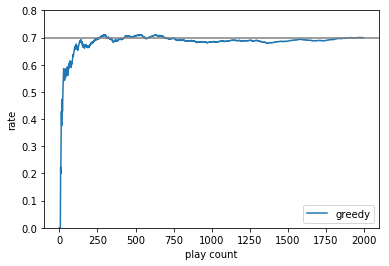

In [51]:
def verification(alg, title):
    plt.plot(np.cumsum(alg.result) / np.arange(1, TRIAL_NUMBER+1),label=title)
    plt.legend(loc='lower right')
    plt.axhline(y=0.7, color='gray')
    plt.xlabel('play count')
    plt.ylabel('rate')
    plt.ylim(0, 0.8)
    plt.show()

verification(greedy, 'greedy')

Greedy algorithmの結果が上のようになりました。  
最初の段階でコインEの結果が良くなかったために、コインDを投げ続けるという選択をとってしまっています。  

### Greedy algorithmの特徴

Greedy algorithmは次のような特徴をもっています。

* 最初の段階で珍しいことが起こってしまうと、その後すべての行動に響いてしまう。
* 報酬の分散がゼロであれば、効率的

In [59]:
class EpsilonGreedy(Greedy):
    def __init__(self, epsilon):
        self.epsilon = epsilon
        super(EpsilonGreedy, self).__init__()

    def choice_coin(self):
        is_random = np.random.choice(
            2, 1, p=[1 - self.epsilon, self.epsilon])[0]
        choiced_coin = (np.random.choice(COINS) if is_random else
                        np.argmax([self.estimate_q(coin) for coin in COINS]))
        return choiced_coin

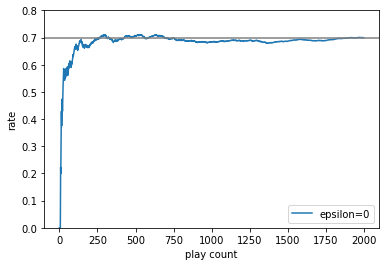

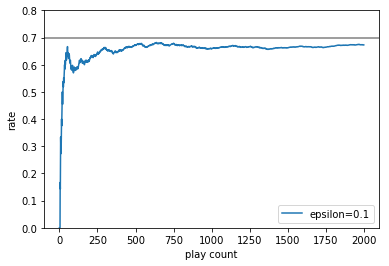

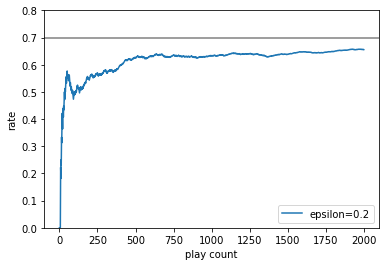

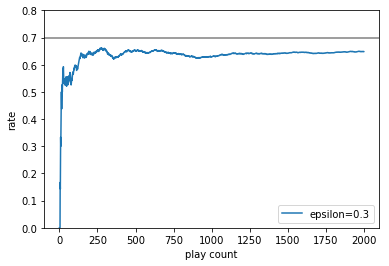

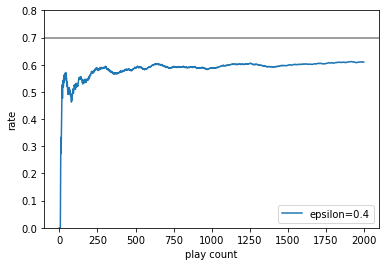

[None, None, None, None, None]

In [60]:
epsilons = [0, 0.1, 0.2, 0.3, 0.4]
epsilon_greedy_list = [EpsilonGreedy(epsilon) for epsilon in epsilons]
[eg.execute() for eg in epsilon_greedy_list]
[verification(eg, 'epsilon='+str(eg.epsilon)) for eg in epsilon_greedy_list]